In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
class PenDigitsDataset(Dataset):
    def __init__(self, data):
        data = np.array(data)
        self.X = data[:, :-1].astype(np.float32)
        self.y = data[:, -1].astype(np.int64)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
file_path = "https://archive.ics.uci.edu/ml/machine-learning-databases/pendigits/pendigits.tra"
dataset = pd.read_csv(file_path,delimiter=',')
dataset.head()

,47,100,27,81,57,37,26,0,0.1,23,56,53,100.1,90,40,98,8
0,0,89,27,100,42,75,29,45,15,15,37,0,69,2,100,6,2
1,0,57,31,68,72,90,100,100,76,75,50,51,28,25,16,0,1
2,0,100,7,92,5,68,19,45,86,34,100,45,74,23,67,0,4
3,0,67,49,83,100,100,81,80,60,60,40,40,33,20,47,0,1
4,100,100,88,99,49,74,17,47,0,16,37,0,73,16,20,20,6


In [ ]:
dataset.isnull().sum()

,0
47,0
100,0
27,0
81,0
57,0
37,0
26,0
0,0
0.1,0
23,0


In [ ]:
dataset = dataset.values.tolist()
dataset = PenDigitsDataset(dataset)

In [ ]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [ ]:
class TransformerWithGaussian(nn.Module):
    def __init__(self, input_dim=16, d_model=64, nhead=4, num_layers=2, num_classes=10, noise_std=0.1):
        super().__init__()
        self.embedding = nn.Linear(2, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(d_model, num_classes)
        self.noise_std = noise_std

    def forward(self, x):
        x = x.view(-1, 8, 2).permute(1, 0, 2)  # (seq_len=8, batch_size, features=2)
        x = self.embedding(x)
        noise = torch.randn_like(x) * self.noise_std
        x = x + noise
        x = self.transformer_encoder(x)
        x = x[-1, :, :]
        logits = self.classifier(x)
        return logits

In [ ]:
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)
            preds = output.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
    accuracy = correct / total
    return accuracy, all_preds, all_labels

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
model = TransformerWithGaussian().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
epochs = 30
train_losses = []
test_accuracies = []

for epoch in range(epochs):
    loss = train(model, train_loader, optimizer, criterion, device)
    train_losses.append(loss)
    acc, _, _ = evaluate(model, test_loader, device)
    test_accuracies.append(acc)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

Epoch 1/30 - Train Loss: 0.2955, Test Accuracy: 0.9420
Epoch 2/30 - Train Loss: 0.2790, Test Accuracy: 0.9046
Epoch 3/30 - Train Loss: 0.3340, Test Accuracy: 0.9199
Epoch 4/30 - Train Loss: 0.2793, Test Accuracy: 0.8993
Epoch 5/30 - Train Loss: 0.2535, Test Accuracy: 0.9333
Epoch 6/30 - Train Loss: 0.2556, Test Accuracy: 0.9280
Epoch 7/30 - Train Loss: 0.2698, Test Accuracy: 0.9386
Epoch 8/30 - Train Loss: 0.2580, Test Accuracy: 0.9333
Epoch 9/30 - Train Loss: 0.2657, Test Accuracy: 0.9440
Epoch 10/30 - Train Loss: 0.2879, Test Accuracy: 0.9360
Epoch 11/30 - Train Loss: 0.2397, Test Accuracy: 0.9226
Epoch 12/30 - Train Loss: 0.2310, Test Accuracy: 0.9146
Epoch 13/30 - Train Loss: 0.2304, Test Accuracy: 0.9326
Epoch 14/30 - Train Loss: 0.2095, Test Accuracy: 0.9553
Epoch 15/30 - Train Loss: 0.2272, Test Accuracy: 0.9153
Epoch 16/30 - Train Loss: 0.2178, Test Accuracy: 0.9380
Epoch 17/30 - Train Loss: 0.2217, Test Accuracy: 0.9500
Epoch 18/30 - Train Loss: 0.2189, Test Accuracy: 0.9166
E

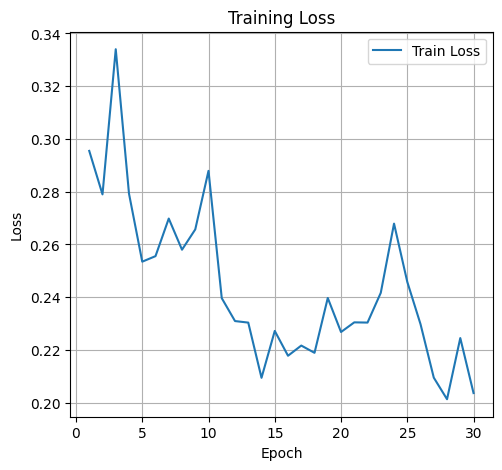

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.legend()

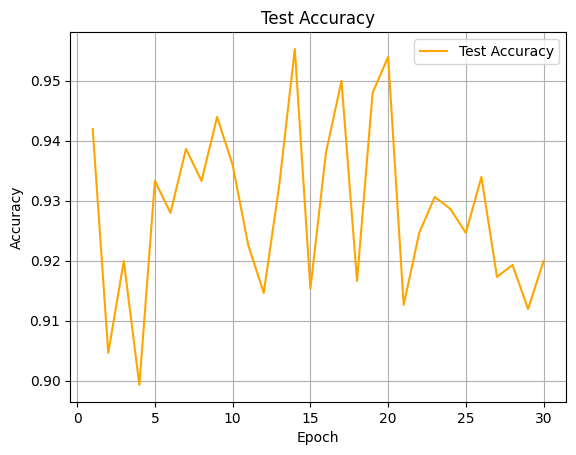

In [ ]:
plt.plot(range(1, epochs+1), test_accuracies, label='Test Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy')
plt.grid(True)
plt.legend()

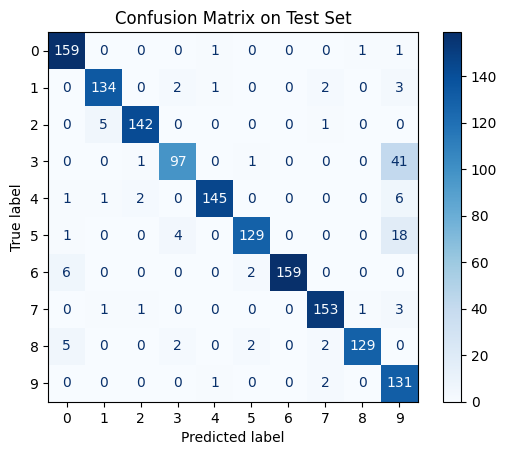

In [ ]:
_, preds, labels = evaluate(model, test_loader, device)
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set")
plt.show()

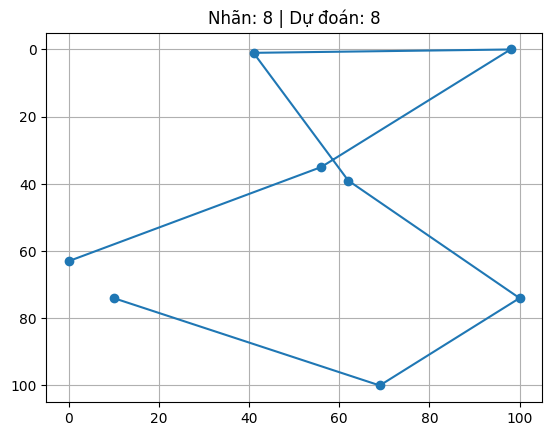

In [ ]:
def visualize_sample(X, y_true, y_pred=None):
    X_tensor = torch.from_numpy(X)
    coords = X_tensor.view(8, 2).numpy()
    x_vals, y_vals = coords[:, 0], coords[:, 1]
    plt.plot(x_vals, y_vals, marker='o')
    plt.title(f"Nhãn: {y_true}" + (f" | Dự đoán: {y_pred}" if y_pred is not None else ""))
    plt.gca().invert_yaxis()
    plt.grid(True)
    plt.show()

X, y_true = test_dataset[1309]
X_tensor = torch.from_numpy(X).unsqueeze(0).to(device)
with torch.no_grad():
    output = model(X_tensor)
    y_pred = output.argmax(dim=1).item()

visualize_sample(X, y_true, y_pred)